In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import csv
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter


In [2]:
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, help="name base of vtk files - they are usually in a vtk-subdirectory!", default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--resolution", type=int, default=10)
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=200)
parser.add_argument("--tmax", type=int, default=10)
parser.add_argument("--Re", type=int, default=400)
args, unknown = parser.parse_known_args()
args = vars(args)
print("ICH FUNKTIONIERE MIT PULLEN")
Re=args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
res = args["resolution"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]




ICH FUNKTIONIERE MIT PULLEN


In [3]:
lattice = lt.Lattice(lt.D3Q27, device = "cpu", dtype=torch.float64)

flow = lt.SuperReducedTaylorGreenVortex3D(resolution=res, reynolds_number=Re, mach_number=0.05, lattice=lattice)
print(flow.units.convert_time_to_lu(tmax))
collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
print(flow.units.relaxation_parameter_lu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.SimulationReducedTGV(flow=flow, lattice=lattice, collision=collision, streaming=streaming)

2205.315581687168
0.5013783222385545


In [4]:
interval_vtk=int((flow.units.convert_time_to_lu(tmax))/200)
interval_out=int((flow.units.convert_time_to_lu(tmax))/200)
Energy = lt.IncompressibleKineticEnergy(lattice, flow)
Dissipation_TGV=lt.Dissipation_TGV(lattice, flow)
reporter = lt.ObservableReporter(Energy, interval=interval_out, out=None)
reporter2= lt.ObservableReporter(Dissipation_TGV, interval=interval_out, out=None)
simulation.reporters.append(reporter)
simulation.reporters.append(reporter2)
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps     time     IncompressibleKineticEnergy
steps     time     Dissipation_TGV


In [5]:
simulation.initialize_f_neq()
steps = int(flow.units.convert_time_to_lu(tmax))
mlups = simulation.step(num_steps=steps)
#print("Performance in MLUPS:", mlups)


In [6]:
energy = np.array(simulation.reporters[0].out)
dissipation = np.array(simulation.reporters[1].out)

dissipationEkin=np.array([energy[:,1],-1/(np.pi*2)**3*np.gradient(64*energy[:,2],energy[:,1])])
dissipationEns=np.array([dissipation[:,1],1/(0.5*np.pi)**3*dissipation[:,3]])
dissipationSij=np.array([dissipation[:,1],dissipation[:,2]])

with open(csvdir + 'DissipationEkin.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEkin)
with open(csvdir + 'DissipationEnstrophy.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEns)
with open(csvdir + 'DissipationSij.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationSij)

[[0.00000000e+00 4.98794825e-02 9.97589650e-02 1.49638448e-01
  1.99517930e-01 2.49397413e-01 2.99276895e-01 3.49156378e-01
  3.99035860e-01 4.48915343e-01 4.98794825e-01 5.48674308e-01
  5.98553790e-01 6.48433273e-01 6.98312755e-01 7.48192238e-01
  7.98071720e-01 8.47951203e-01 8.97830685e-01 9.47710168e-01
  9.97589650e-01 1.04746913e+00 1.09734862e+00 1.14722810e+00
  1.19710758e+00 1.24698706e+00 1.29686655e+00 1.34674603e+00
  1.39662551e+00 1.44650499e+00 1.49638448e+00 1.54626396e+00
  1.59614344e+00 1.64602292e+00 1.69590241e+00 1.74578189e+00
  1.79566137e+00 1.84554085e+00 1.89542034e+00 1.94529982e+00
  1.99517930e+00 2.04505878e+00 2.09493827e+00 2.14481775e+00
  2.19469723e+00 2.24457671e+00 2.29445620e+00 2.34433568e+00
  2.39421516e+00 2.44409464e+00 2.49397413e+00 2.54385361e+00
  2.59373309e+00 2.64361257e+00 2.69349206e+00 2.74337154e+00
  2.79325102e+00 2.84313050e+00 2.89300999e+00 2.94288947e+00
  2.99276895e+00 3.04264843e+00 3.09252792e+00 3.14240740e+00
  3.1922

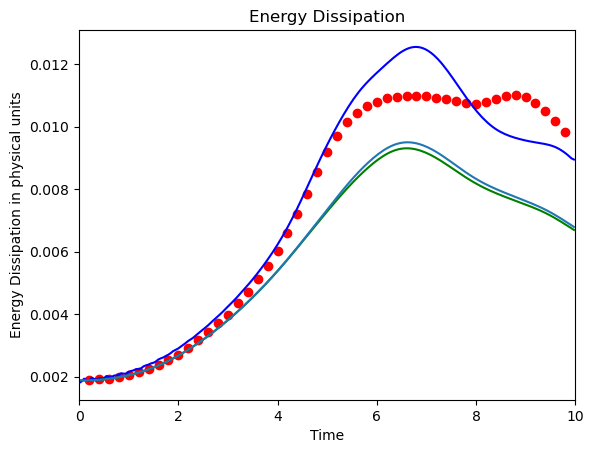

In [7]:
csv_file_path = '/home/ben/Schreibtisch/Enstropy Brachet/Brachet/Brachet_1983_tgv3d_enstrophy_Re400.csv'

# Daten aus der CSV-Datei lesen
csv_data = []
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter=';')
    for row in csv_reader:
        csv_data.append(row)

csv_data = np.array(csv_data, dtype=float)
print(dissipationEkin)

plt.plot(dissipationEkin[0,:],dissipationEkin[1,:],color = 'blue')
plt.plot(dissipationEns[0,:],dissipationEns[1,:], color = 'green')
plt.xlim(0,10)
plt.plot(dissipationSij[0,:],dissipationSij[1,:])
plt.scatter(csv_data[:, 0], csv_data[:, 1], color='red', label='CSV Data')
plt.title('Energy Dissipation')
plt.xlabel('Time')
plt.ylabel('Energy Dissipation in physical units')
plt.show()